# Moving in 2D

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S42_logistics_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle
from matplotlib.transforms import Affine2D

import gtsam
from gtbook.display import show

N = 5
indices = range(1, N+1)
u = {k:gtsam.symbol('u',k) for k in indices[:-1]} # controls u_k
x = {k:gtsam.symbol('x',k) for k in indices}      # states x_k


```{index} action; omnidirectional motion
```

> Omniwheels are a great way to move omni-directionally in 2D.

<img src="Figures4/S42-Warehouse_robots-05.jpg" alt="Splash image with robot balancing" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

## Omni Wheels
> Omni wheels make omnidirectional movement possible.

An [omni wheel](https://en.wikipedia.org/wiki/Omni_wheel) is a wheel that, instead of a tire, has small rollers along its rim. The axes for these rollers are perpendicular to the wheel's own axis. Because of this, unlike a conventional wheel, movement perpendicular to the wheel is *not* resisted, i.e., the wheel can slide effortlessly from left to right. Figure [1](#fig:rotacaster) (from Wikipedia) shows an example.

<figure id="fig:rotacaster">
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Triple_Rotacaster_commercial_industrial_omni_wheel.jpg" style="width:12cm" alt="">
<figcaption>Triple Rotacaster commercial industrial omni wheel.
        <small>
            <a href="https://creativecommons.org/licenses/by/1.0" target="_blank">CC BY 1.0</a> via 
            <a href="https://commons.wikimedia.org/wiki/File:Triple_Rotacaster_commercial_industrial_omni_wheel.jpg" target="_blank">Wikimedia Commons</a>.
        </small>
</figcaption>



Apart from being potentially amazing for parallel parking, in robotics omni wheels are very popular because they enable omni-directional movement of robot platforms. 

As an example, let us imagine that our warehouse robot is circular and has three omni wheels mounted on its rim. The coordinates of each wheel, in body coordinates, are
\begin{equation}
\begin{aligned}
p^i_x &= R \cos(\theta^i) \\
p^i_y &= R \sin(\theta^i) \\
\theta^i &= i \frac{2\pi}{3}
\end{aligned}
\end{equation}
where $R$ is the radius of the robot. The angle $\theta^i$ is angle between the robot's x-axis and the wheel's axis.
As we will see below, this configuration of wheels allows the robot to move instantaneously in any direction in the plane.

In code, we create a small function:

In [3]:
R = 0.50 # robot is circular with 50 cm radius
r, w = 0.20, 0.06 # wheel radius and width
num_wheels = 3

def wheel_pose(i:int):
    """Return x,y, and theta for wheel with given index."""
    theta = float(i)*np.pi*2/num_wheels
    px, py = R*np.cos(theta), R*np.sin(theta)
    return px, py, theta

This yields the configuration in Figure [2](#fig:omni_wheel).

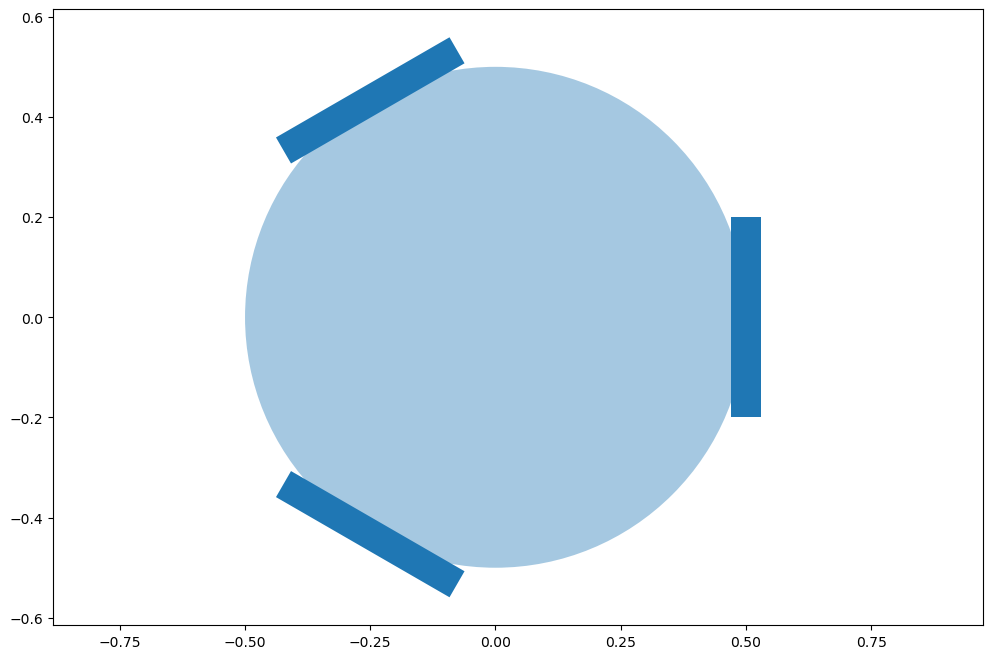

In [4]:
#| caption: Omni wheel configuration.
#| label: fig:omni_wheel
fig, ax = plt.subplots(figsize=(12,8))

circle = Circle((0, 0), R, alpha=0.4)
ax.add_artist(circle)

wheels = []
for i in range(3):
    px, py, theta = wheel_pose(i)
    wheel = Rectangle((-w/2, -r), w, 2*r)
    wheel.set_transform(Affine2D().rotate(theta).translate(px, py))
    wheels.append(wheel)

ax.add_collection(PatchCollection(wheels))
ax.axis('equal'); plt.show()


## Kinematics of Omni Wheels

> Relating the robot velocity to the wheel velocities.

Kinematics is the study of motion, without regard for the forces required to cause the motion.
In particular, for our omni-directional robot, kinematics addresses the question "What should the individual wheel velocities be, given that we want the robot to move with a certain velocity?"

The key property of omni-wheels is that they roll without slipping in the steering direction,
but roll freely in the perpendicular direction (sometimes called the slipping direction).
In Figure [3](#fig:omni-wheel-frame), these directions correspond to the unit vectors $u_\|$ (steering direction)
and $u_\perp$ (slipping direction).
These vectors define an orthogonal decomposition of the robot's motion.
The wheel actuators directly produce motion in the direction $u_\|$,
and the robot moves freely in the direction $u_\perp$.

<figure id="fig:omni-wheel-frame">
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/omni-wheel-frame.png?raw=1" style="width:14cm" alt="">
<figcaption>Orthogonal coordinate frame for a single omni-wheel.</figcaption>
</figure>

The vectors $u_\|$ and $u_\perp$
are defined in the local coordinate frame of the robot, but since our robot
does not rotate, we can define them directly in the world coordinate frame.
Let $\theta$ denote the angle from the world $x$-axis to the axle axis of the wheel.
The vectors $u_\|$ and $u_\perp$ are given by
\begin{equation}
u_\| =\left[ \begin{array}{c} -\sin \theta \\ \cos \theta \end{array}\right]
\;\;\;\;\;\;\; \rm{and} \;\;\;\;\;\;\;
u_\perp =\left[ \begin{array}{c} \cos \theta \\ \sin \theta \end{array}\right]
\end{equation}

```{index} translational velocity
```
When an object moves with a purely translational motion (i.e., there is no rotation), every point
on the object moves with the same velocity.
Suppose that the robot, and therefore this specific wheel,
moves with  the **translational velocity** $v=(v_x, v_y)$, as shown in Figure [4](#fig:wheel-velocity). 
We can decompose the velocity $v$ into components that are parallel and perpendicular to the
steering direction by projecting $v$ onto the vectors $u_\|$ and $u_\perp$.

<figure id="fig:wheel-velocity">
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/wheel-velocity.png?raw=1" style="width:14cm" alt="">
<figcaption>Wheel velocity v.</figcaption>
</figure>

In particular, we can write
\begin{equation}
\begin{aligned}
v &= (v \cdot u_\| )u_\| + (v \cdot u_\perp) u_\perp \\
&=
(- v_x \sin \theta + v_y \cos \theta) u_\|
+
(v_x \cos \theta + v_y \sin \theta) u_\perp \\
&= v_{\parallel}u_\| +  v_{\perp}u_\perp\\
\end{aligned}
\end{equation}
which gives
\begin{equation}
\begin{aligned}
v^i_{\parallel} &= - v_x \sin \theta^i + v_y \cos \theta^i \\
v^i_{\perp} &= v_x \cos \theta^i + v_y \sin \theta^i
\end{aligned}
\end{equation}
Note that in the above equation there is some possible confusion in the notation:
$u_\|$ and $u_\perp$ are unit vectors that denote directions of motion,
while $v_{\parallel}$ and $v_{\perp}$ are scalar quantities (the speed in the directions
of the unit vectors $u_\|$ and $u_\perp$, respectively).

In code:

In [5]:
def wheel_velocity(vx:float, vy:float, i:int):
    """Calculate parallel and perpendicular velocities at wheel i"""
    _, _, theta = wheel_pose(i)
    para = - vx * np.sin(theta) + vy * np.cos(theta)
    perp =   vx * np.cos(theta) + vy * np.sin(theta)
    return para, perp

In Figure [5](#fig:omni_wheel_velocity) we use this to show how the desired velocity (in blue) translates graphically to parallel (purple) and perpendicular (green) velocity components at the wheel sites.

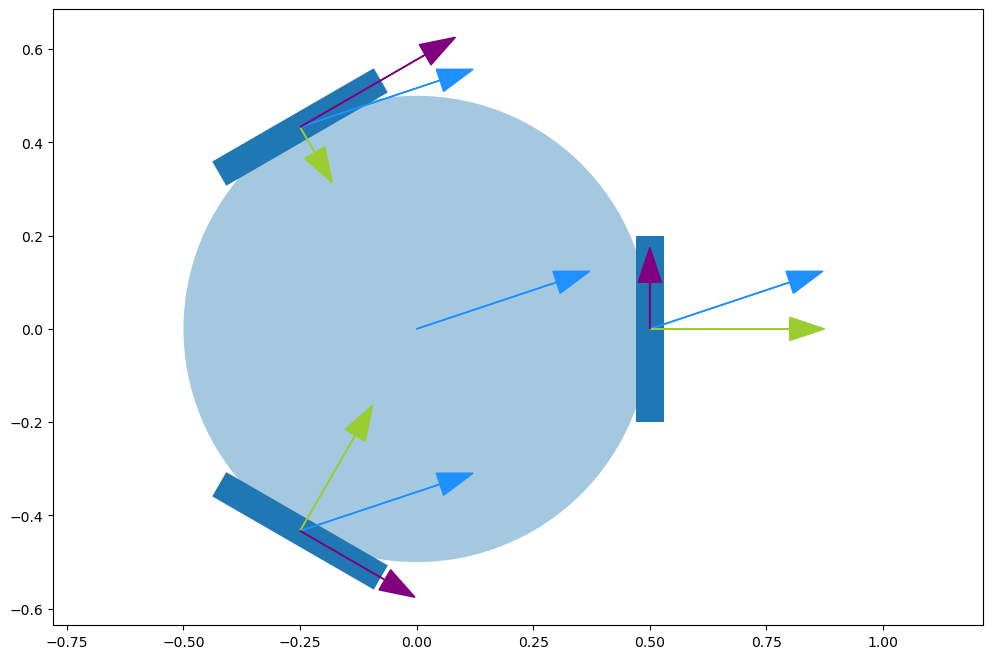

In [6]:
#| caption: Velocity decomposition for the omni wheels.
#| label: fig:omni_wheel_velocity
vx, vy = 0.3, 0.1 # change these !

fig, ax = plt.subplots(figsize=(12,8))

circle = Circle((0, 0), R, alpha=0.4)
ax.add_artist(circle)

wheels = []
for i in range(3):
    px, py, theta = wheel_pose(i)
    wheel = Rectangle((-w/2, -r), w, 2*r)
    wheel.set_transform(Affine2D().rotate(theta).translate(px, py))
    wheels.append(wheel)
ax.add_collection(PatchCollection(wheels))


plt.arrow(0, 0, vx, vy, head_width=0.05, color="dodgerblue")
for i in range(3):
    px, py, theta = wheel_pose(i)
    para, perp = wheel_velocity(vx, vy, i)
    plt.arrow(px, py, vx, vy, head_width=0.05, color="dodgerblue")
    plt.arrow(px, py, np.cos(theta)*perp, np.sin(theta)*perp, head_width=0.05, color="yellowgreen")
    plt.arrow(px, py, -np.sin(theta)*para, np.cos(theta)*para, head_width=0.05, color="purple")

ax.axis('equal'); plt.show()


## The Jacobian Matrix

```{index} sliding direction, driving direction, Jacobian matrix
```
As mentioned above, the motion *perpendicular* to the wheel is not resisted by the rollers: they will roll freely
at exactly the right speed to accommodate any movement in this direction. Because this allows the wheel to "slide", we also call this the **sliding direction**.

On the other hand, the contact of each wheel must move exactly opposite to the parallel or **driving direction** of the velocity.
As a consequence, if the radius of each wheel is $r$, the wheel's angular velocity $\omega^i$ (i.e., the angular rate at which the wheel spins about its axle)
must satisfy
\begin{equation}
\omega^i = \frac{v^i_\parallel}{r} = 
\frac{1}{r} (-\sin \theta^i, \cos \theta^i) \begin{pmatrix}v_x \\ v_y \end{pmatrix}
\end{equation}

Because we have three wheels, we can stack three instances of the above equation
to obtain a matrix equation
that maps a desired robot velocity $v=(v_x,v_y)$ to the appropriate commanded wheel velocities:
\begin{equation}
\begin{pmatrix}\omega^1 \\ \omega^2 \\ \omega^3 \end{pmatrix} 
= \frac{1}{r} \begin{pmatrix}- \sin\theta^1 & \cos\theta^1 \\ - \sin\theta^2 & \cos\theta^2 \\ - \sin\theta^3 & \cos\theta^3 \end{pmatrix}
\begin{pmatrix}v_x \\ v_y \end{pmatrix}
\end{equation}
in which the $3\times2$ matrix is called the **Jacobian matrix**.

For the three regularly arranged omni wheels with $\theta^1=0$, $\theta^2=2\pi/3$, and $\theta^3=4\pi/3$ this becomes
\begin{equation}
\begin{pmatrix}\omega^1 \\ \omega^2 \\ \omega^3 \end{pmatrix} 
= \frac{1}{r} \begin{pmatrix}0 & 1 \\ -0.866 & -0.5 \\ 0.866 & -0.5  \end{pmatrix}
\begin{pmatrix}v_x \\ v_y \end{pmatrix}.
\end{equation}

In [7]:
def jacobian_matrix():
    """Compute matrix converting from velocity to wheel velocities."""
    rows = []
    for i in range(num_wheels):
        _, _, theta = wheel_pose(i)
        rows.append([-np.sin(theta), np.cos(theta)])
    return np.array(rows)/r

We can verify that doing the matrix-velocity multiplication yields the same result as using the `wheel_velocity` function:

In [8]:
for i in range(3):
    para, perp = wheel_velocity(vx, vy, i)
    print(f"wheel {i}: {para/r}")

print("\nUsing matrix method:")
print(jacobian_matrix() @ gtsam.Point2(vx, vy))

wheel 0: 0.5
wheel 1: -1.549038105676658
wheel 2: 1.0490381056766573

Using matrix method:
[ 0.5        -1.54903811  1.04903811]


## Omni-directional Movement in Practice

> Expressing motion relative to a reference coordinate frame.

To summarize, given a velocity, $v$, in the robot's body coordinates,
we compute the corresponding vector of angular wheel velocities using the Jacobian mapping, $\omega = Jv$.
The above exposition can be directly generalized to an arbitrary number of wheels, mounted in arbitrary locations. Some care needs to be taken that the chosen configuration is not singular, which would result in the robot being able to move only in one particular direction (or not at all!).

In general, we would like to be able to specify the robot's direction of motion relative
to arbitrary coordinate frames, e.g., to a fixed warehouse coordinate frame,
or a *world coordinate frame*.
In this chapter we have assumed that the robot orientation is aligned with the warehouse orientation, so conveniently velocity vectors in either frame have the same coordinates.
However, if we were to include the robot's orientation in the state representation, we would need to rotate the desired world velocity into the body coordinate frame. We will see how to do this later in this book.

If we *do* care about orientation, omni wheels can actually be used to *rotate* the robot as  well as to induce pure translational motion. Think about applying the same constant angular velocity to all three wheels: the robot will now simply rotate in place. To represent this mathematically, we could add a *third* column to the Jacobian matrix that maps a desired angular velocity into wheel velocities. This would allow us to command any combination of linear and angular velocity to the robot.

Finally, there is a more general type of wheel, the "mecanum wheel", for which the rollers are *not* aligned with the wheel rim, but are rotated by some (constant) amount. That complicates the math a little bit, but in the end we will again obtain a Jacobian matrix that maps robot velocity to wheel angular velocities. We will not discuss this further.

## A Gaussian Dynamic Bayes Net

> Modeling stochastic action in continuous spaces can again be done using DBNs.

```{index} pair: continuous DBNs; continuous dynamic Bayes nets
```
Modeling with continuous densities can be done with *continuous* dynamic Bayes nets (DBNs). 
Omni-wheels are notoriously flaky in the execution, especially on uneven ground or carpet.
Hence, it is important to model the uncertainty associated with commanded movements.
If we are model our robot as a discrete-time system,
$u_k = v \Delta T$ is the displacement that occurs when the robot
moves with constant velocity $v$ for time $\Delta T$.
Since the velocity can be in any direction, we have $u_k\in\mathbb{R}^2$.
In the absence of uncertainty, our motion model would simply
be $x_{k+1} = x_k + u_k$.

```{index} control variables
```
Given the uncertainty inherent to the use of omni-wheels, we will instead develop a probabilistic
motion model.
Recall that we created a DBN with discrete actions, states, and measurements in the previous chapter. Here we do the same, except with *continuous* densities, specifying a DBN that encodes the joint density $p(X|U)$ on the continuous states $X\doteq\{x_k\}_{k=1}^N$,
\begin{equation}
p(X|U) = p(x_1) \prod_{k=2}^{N} p(x_{k}|x_{k-1}, u_{k-1})
\end{equation}
where we assume that the **control variables** $U\doteq\{u_k\}_{k=1}^{N-1}$ are *given* to us.

Let us assume we *know* that the robot starts out in the warehouse at coordinates $\mu_1 =(20,10)^T$, with some noise/error in position of magnitude on the order of plus or minus half a meter. We can encode this knowledge into a continuous Gaussian prior as
\begin{equation}
p(x_1) = \mathcal{N}(x_1;\mu=\mu_1,\Sigma=P) \propto \exp\{ - \frac{1}{2} (x_1-\mu_1)^TP^{-1}(x_1-\mu_1) \}
\end{equation}
with the covariance matrix $P=\text{diag}(0.5^2,0.5^2)$.

```{index} conditional Gaussian density, Gaussian motion model
```
A Gaussian *motion model* is a bit trickier. 
Here we need a *conditional* Gaussian density that depends on the current state
and the commanded motion.
The usual way to incorporate uncertainty into a motion model is to assume that
a random disturbance is added to the nominal motion of the robot.
We can model this as
\begin{equation}
x_{k+1} = x_k + u_k + w_k
\end{equation}
in which $w_k$ is a random vector whose probability distribution is typically based on empirical
observations of the system. In our case, we will assume that this disturbance
is Gaussian, $w_k \sim N(\mu,\Sigma)$.
In this case, it can be shown that the conditional distribution of $x_{k+1}$
given $x_k$ and $u_k$ is given by a **conditional Gaussian density** of the form
\begin{equation}
p(x_{k+1}|x_{k}, u_k) = \mathcal{N}(x_{k_1}; x_{k} +  u_k, \Sigma)
\end{equation}
i.e., the conditional distribution for the next state is a Gaussian, with mean equal to the
nominal (i.e., noise-free) next state $x_k + u_k$, and variance equal to the variance of the uncertainty 
in the motion model.

It is easy to generalize this motion model to linear systems of the form
\begin{equation}
x_{k+1} = A x_k + B u_k + w_k
\end{equation}
which is the general form for a linear time-invariant (LTI) system with additive noise.
The matrix $A \in \mathbb{R}^{n \times n}$ is called the system matrix,
and the matrix $B$ maps control input $u_k$ to a vector in the state space.
The motion model for this general LTI system is given by
\begin{equation}
p(x_{k+1}|x_{k}, u_k) = \mathcal{N}(x_{k+1};\mu=A x_{k} + B u_k, \Sigma=Q)
\end{equation}
where $Q$ is the traditional symbol used for motion model covariance. If we assume the robot executes action $u_k$ with a standard deviation of 0.2m, then we will have $Q=\text{diag}(0.2^2,0.2^2)$. 

## Gaussian DBNs in Code


In GTSAM, a Gaussian density is specified using the class `GaussianDensity`, which corresponds to a negative log-probability given by 
\begin{equation}
\frac{1}{2 \sigma^2} \|x - \mu\|^2.
\end{equation}
with a named constructor `FromMeanAndStddev` that takes $\mu$ and $\sigma$ as arguments.
For their part, Gaussian *conditional* densities are specified using the class `GaussianConditional`, which correspond to a negative log-probability given by 
\begin{equation}
\frac{1}{2 \sigma^2} \|x - (A_1 p_1 + A_2 p_2 + b)\|^2.
\end{equation}
i.e., the mean on $x$ is a linear function of the conditioning variables $p_1$ and $p_2$. Again, a named constructor `FromMeanAndStddev` is there to assist us. Details are given in the GTSAM 101 section at the end of this section, as always.

All of the above is used in the following piece of code, which builds the dynamic Bayes net in Figure [6](#fig:gaussian_bayes_net).

In [9]:
gaussianBayesNet = gtsam.GaussianBayesNet()
A, B = np.eye(2), np.eye(2)
motion_model_sigma = 0.2
for k in reversed(indices[:-1]):
    gaussianBayesNet.push_back(gtsam.GaussianConditional.FromMeanAndStddev(
        x[k+1], A, x[k], B, u[k], [0, 0], motion_model_sigma))
p_x1 = gtsam.GaussianDensity.FromMeanAndStddev(x[1], [20,10], 0.5)
gaussianBayesNet.push_back(p_x1)

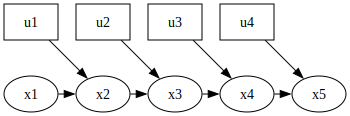

In [10]:
#| caption: A Gaussian dynamic Bayes net.
#| label: fig:gaussian_bayes_net
position_hints = {'u': 2, 'x': 1}
show(gaussianBayesNet, hints=position_hints, boxes=set(list(u.values())))

### Exercise

Note that we used a constant motion model noise here, which is perhaps unrealistic: if a robot is commanded to go further, it could be expected to do a worse job at going exactly the distance it was supposed to go. How could you modify the above code to account for that?

## Simulating a Continuous Trajectory

> Bayes nets are great for simulation.

```{index} control tape
```
Let us now create a simulated trajectory in our example warehouse, by specifying a "control tape" and using the dynamic Bayes net created above to do the heavy lifting for us:

In [11]:
control_tape = gtsam.VectorValues()
for k, (ux,uy) in zip(indices[:-1], [(2,0), (2,0), (0,2), (0,2)]):
    control_tape.insert(u[k], gtsam.Point2(ux,uy))
control_tape


Variable,value
u1,2 0
u2,2 0
u3,0 2
u4,0 2


In [12]:
gaussianBayesNet.sample(control_tape)


Variable,value
u1,2 0
u2,2 0
u3,0 2
u4,0 2
x1,20.6469 10.199
x2,22.8706 9.90054
x3,24.8089 10.1832
x4,25.1275 12.2733
x5,25.0941 14.5563


## GTSAM 101

> The GTSAM concepts used in this section, explained.

A `GaussianDensity` class can be constructed via the following named constructor:

```python
FromMeanAndStddev(key: gtsam.Key, mean: np.array, sigma: float) -> gtsam.GaussianDensity
```

{raw:tex}`\noindent`
and two similar named constructors exists for `GaussianConditional`:

```python
- FromMeanAndStddev(key: gtsam.Key, A: np.array, parent: gtsam.Key, b: numpy.ndarray[numpy.float64[m, 1]], sigma: float) -> gtsam.GaussianConditional
      
- FromMeanAndStddev(key: gtsam.Key, A1: np.array, parent1: gtsam.Key, A2: np.array, parent2: gtsam.Key, b: np.array, sigma: float) -> gtsam.GaussianConditional
```

Both classes support some other methods that can come in handy, as demonstrated here on the prior created above:

In [13]:
print(p_x1) # printing

values = gtsam.VectorValues()
values.insert(x[1], [19,12])

e = p_x1.unweighted_error(values)
print(f"unweighted error vector = {e}")

w = p_x1.error_vector(values)
print(f"weighted error vector = {w}")

E  = p_x1.error(values)
print(f"error 0.5 w'*w = {E}")
assert E == 0.5 * w.dot(w) # check 10 == (4+16)/2


GaussianDensity: density on [x1] 
mean: [20; 10];
covariance: [
	0.25, 0;
	0, 0.25
]
isotropic dim=2 sigma=0.5

unweighted error vector = [-1.  2.]
weighted error vector = [-2.  4.]
error 0.5 w'*w = 10.0


In the above, all error functions take an instance of `VectorValues`, which is simply a map from GTSAM keys to values as vectors. This is the equivalent of `DiscreteValues` from the previous sections.